# Ratio KE/PE
### Computes the spectral ratio between ocean KE and PE at the surface using CROCO


In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import sys
import seawater as sw
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle

from dask.diagnostics import ProgressBar

import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [2]:

# plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [3]:
def spec_ogive(spec,kr):
    
    Ogive_Kr=np.array(kr)
    # Middle Value Wavenumber position for plot
    Ogive_Krx=(Ogive_Kr[:-1]+Ogive_Kr[1:])/2
    # dK=np.diff(Ogive_Kr)[0]
    
    #Flipped Integration in wavenumber and then flipped again
    Ogive_inv=integ.cumtrapz(y=spec[::-1],x=Ogive_Kr[::-1]);
    Ogive_Spec=-Ogive_inv[::-1];


    return Ogive_Krx,Ogive_Spec

def ogive(deltaf,G):
   '''
   ogive(deltaf,G): use very simple integration to calculate the ogive 
   from a spectrum G with data sampled at frequency deltaf.
   2017-01-10T09:40:31 going back to a single frequency for Os and Gs
   '''
# --------------------------------------------------------------------
# 2016-10-08T09:47:12 re-created with numpy
# --------------------------------------------------------------------
   M1 = len(G)
   Og = np.zeros(M1,float)
   Og[0:M1] = np.cumsum(np.flipud(G[0:M1]))
   Og *= deltaf
   Og = np.flipud(Og)
   return Og



In [4]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [5]:
dxx=0.5
dyy=dxx

In [6]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
t_ind_h=varf.time_counter


mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

## Calculating surface PE

In [7]:
chunks_new={'time_counter':120}

In [ ]:
rho_interp_full=rho_full_psi[iy].xroms.isoslice(z_interp).compute()
b_interp_full=xroms.buoyancy(rho_interp_full)


Bf_spec=xrft.isotropic_power_spectrum(b_interp_full.drop(['nav_lat_rho', 'nav_lon_rho']),
                                  dim=['eta_rho','xi_rho'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor)

In [8]:
rho_full=varf.rho[:,120:-120,120:800].compute()
rho_smth=vart.rho[:,120:-120,120:800].compute()

In [34]:
N2r=2.1757166666666666e-05 #caculated from FULL

In [10]:
%%time


tf=varf.temp#.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,120:-120,120:800].compute();

tt=vart.temp#.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,120:-120,120:800].compute();


CPU times: user 4.91 s, sys: 5.63 s, total: 10.5 s
Wall time: 1min 30s


In [11]:
%%time


sf=varf.salt#.groupby("time_counter.dayofyear").mean()
sf=sf.chunk(chunks=chunks_new);
sf=sf[:,120:-120,120:800].compute();

st=vart.salt#.groupby("time_counter.dayofyear").mean()
st=st.chunk(chunks=chunks_new);
st=st[:,120:-120,120:800].compute();

CPU times: user 4.85 s, sys: 5.73 s, total: 10.6 s
Wall time: 1min 29s


In [14]:
import xroms 

rhof=xroms.potential_density(tf,sf)
rhot=xroms.potential_density(tt,st)

In [31]:
alphaf=sw.alpha(sf,tf,p=0)
alphat=sw.alpha(st,tt,p=0)
betaf=sw.beta(s=sf,t=tf,p=0)
betat=sw.beta(s=st,t=tt,p=0)
g=9.8

In [32]:
# bf=-(g/1025)*(rhof-1025)
# bt=-(g/1025)*(rhot-1025)


bf=-(g/1025)*(rhof-1025)
bt=-(g/1025)*(rhot-1025)

# bf=-(g/1025)*(rho_full)
# bt=-(g/1025)*(rho_smth)

# bf=xroms.buoyancy(rhof-1025)#[:,1:-1,:]
# bt=xroms.buoyancy(rhot-1025)#[:,1:-1,:]

In [33]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'

In [97]:
%%time
with ProgressBar():
    alphaBf=xrft.isotropic_power_spectrum((alphaf*g*(tf-tf.mean())).drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    alphaBt=xrft.isotropic_power_spectrum((alphat*g*(tt-tt.mean())).drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

CPU times: user 34min 19s, sys: 1h 50min 32s, total: 2h 24min 51s
Wall time: 3min 30s


In [100]:

with ProgressBar():
    betaBf=xrft.isotropic_power_spectrum((-betaf*g*(sf-sf.mean())).drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    betaBt=xrft.isotropic_power_spectrum((-betat*g*(st-st.mean())).drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

In [35]:
%%time
with ProgressBar():
    Bf=xrft.isotropic_power_spectrum(bf.drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    Bt=xrft.isotropic_power_spectrum(bt.drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

CPU times: user 26min 36s, sys: 1h 5min 43s, total: 1h 32min 20s
Wall time: 2min 17s


In [102]:
# N2r=(5.2*10**-3)**2

In [103]:
Epe_alpha_f=(1/(2*N2r))*alphaBf
Epe_alpha_t=(1/(2*N2r))*alphaBt
Epe_beta_f=(1/(2*N2r))*betaBf
Epe_beta_t=(1/(2*N2r))*betaBt

In [36]:
Epef=(1/(2*N2r))*Bf
Epet=(1/(2*N2r))*Bt

## Calculating surface KE

In [37]:
%%time
uf=varf.u#.groupby("time_counter.dayofyear").mean()
uf=uf.chunk(chunks=chunks_new);
# u_f=(uf[:,1:,:]+uf[:,:-1,:])/2
uf=uf.compute();

ut=vart.u#.groupby("time_counter.dayofyear").mean()
ut=ut.chunk(chunks=chunks_new);
# ut=(ut[:,1:,:]+ut[:,:-1,:])/2
ut=ut.compute();

vf=varf.v#.groupby("time_counter.dayofyear").mean()
vf=vf.chunk(chunks=chunks_new);
# vf=(vf[:,:,1:]+vf[:,:,:-1])/2
vf=vf.compute();

vt=vart.v#.groupby("time_counter.dayofyear").mean()
vt=vt.chunk(chunks=chunks_new);
# vt=(vt[:,:,1:]+vt[:,:,:-1])/2
vt=vt.compute();



CPU times: user 9.53 s, sys: 12.3 s, total: 21.8 s
Wall time: 3min 5s


In [38]:
uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
uf,vf=uf[:,120:-120,120:800],vf[:,120:-120,120:800]

ut,vt,_=romspickle.uvw2rho_3d(ut,vt,ut)
ut,vt=ut[:,120:-120,120:800],vt[:,120:-120,120:800]

In [39]:
with ProgressBar():
    Uf=xrft.isotropic_power_spectrum(uf,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vf=xrft.isotropic_power_spectrum(vf,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Ut=xrft.isotropic_power_spectrum(ut,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vt=xrft.isotropic_power_spectrum(vt,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

In [40]:
Ekef=xr.DataArray(data=0.5*(Uf.data + Vf.data),coords=({'time_counter':Uf.time_counter,'freq_r':Uf.freq_r.data}))
Eket=xr.DataArray(data=0.5*(Ut.data + Vt.data),coords=({'time_counter':Uf.time_counter,'freq_r':Uf.freq_r.data}))

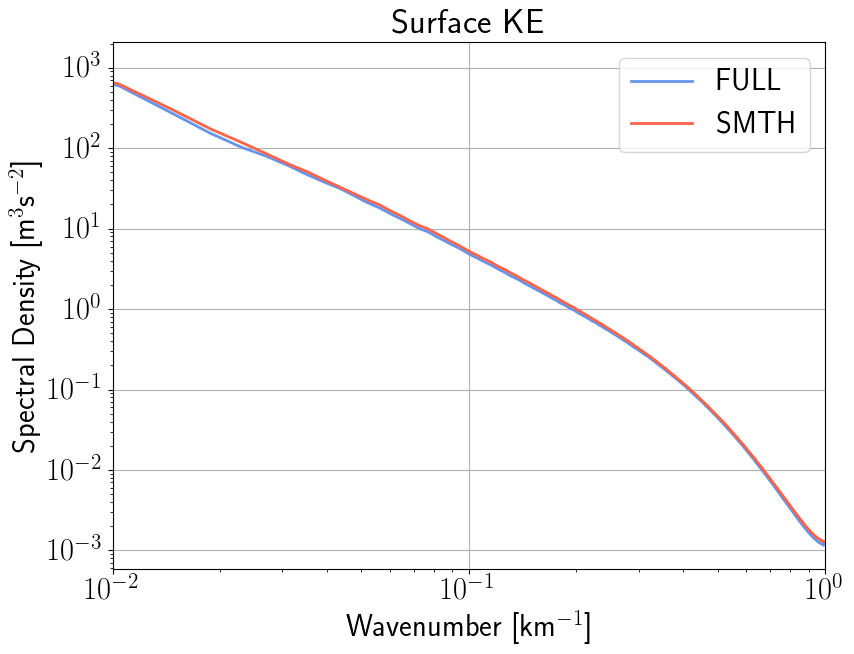

In [159]:

plt.figure(figsize=(9,7))


plt.plot((Ekef.freq_r/dxx),Ekef.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((Eket.freq_r/dxx),Eket.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
plt.ylabel(r'Spectral Density [m$^{3}$s$^{-2}$]',fontweight='bold')

plt.title(r'Surface KE ',fontsize=25,fontweight='bold')
plt.yscale('log')
plt.xscale('log')

# plt.ylim(0.001,2)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()

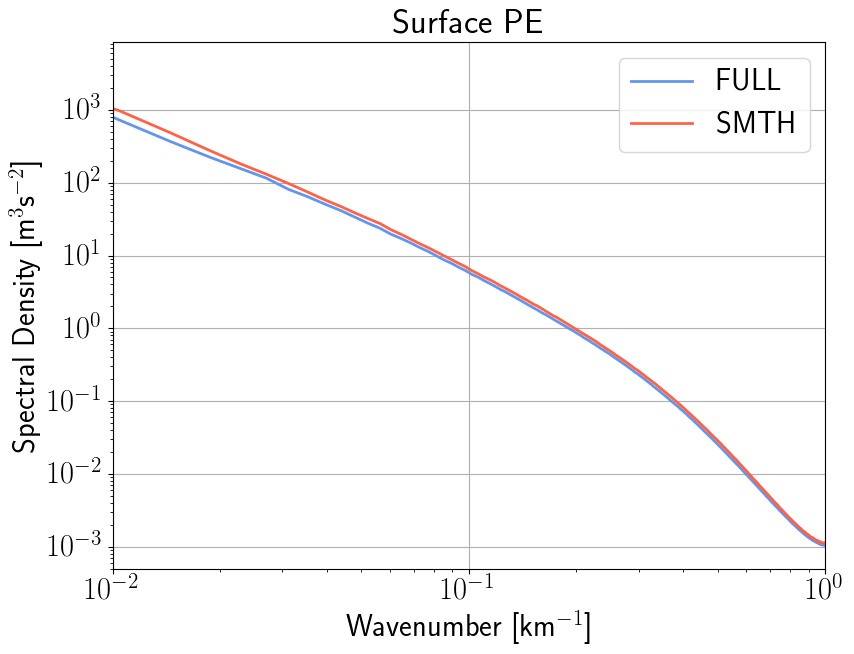

In [160]:

plt.figure(figsize=(9,7))


plt.plot((Epef.freq_r/dxx),Epef.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((Epet.freq_r/dxx),Epet.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
plt.ylabel(r'Spectral Density [m$^{3}$s$^{-2}$]',fontweight='bold')


plt.title(r'Surface PE',fontsize=25,fontweight='bold')
# plt.yscale('symlog', linthresh=1e-4)
plt.xscale('log')
plt.yscale('log')


# plt.ylim(0.001,2)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()

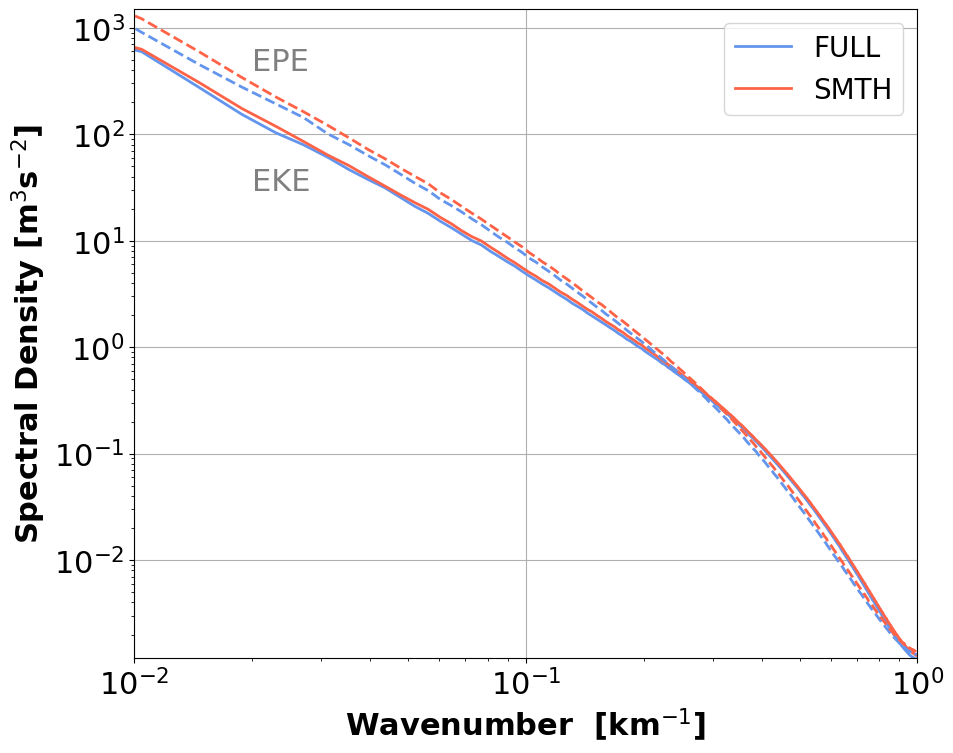

In [71]:

plt.figure(figsize=(10,8))



plt.plot((Ekef.freq_r/dxx),Ekef.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((Eket.freq_r/dxx),Eket.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')


plt.plot((Epef.freq_r/dxx),Epef.mean(axis=0)/dxx*1e3,linestyle='--',linewidth=2,color='cornflowerblue')
plt.plot((Epet.freq_r/dxx),Epet.mean(axis=0)/dxx*1e3,linestyle='--',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.text(2e-2,3e1,r'EKE',color='grey')

plt.text(2e-2,0.4e3,r'EPE',color='grey')



plt.legend(fontsize=20)

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
plt.ylabel(r'Spectral Density [m$^{3}$s$^{-2}$]',fontweight='bold')

# plt.title(r'Surface KE ',fontsize=25,fontweight='bold')
plt.yscale('log')
plt.xscale('log')

plt.ylim(1.2e-3,1.5e3)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/PE+KE_spectral.png')



# Thermal and haline PE components

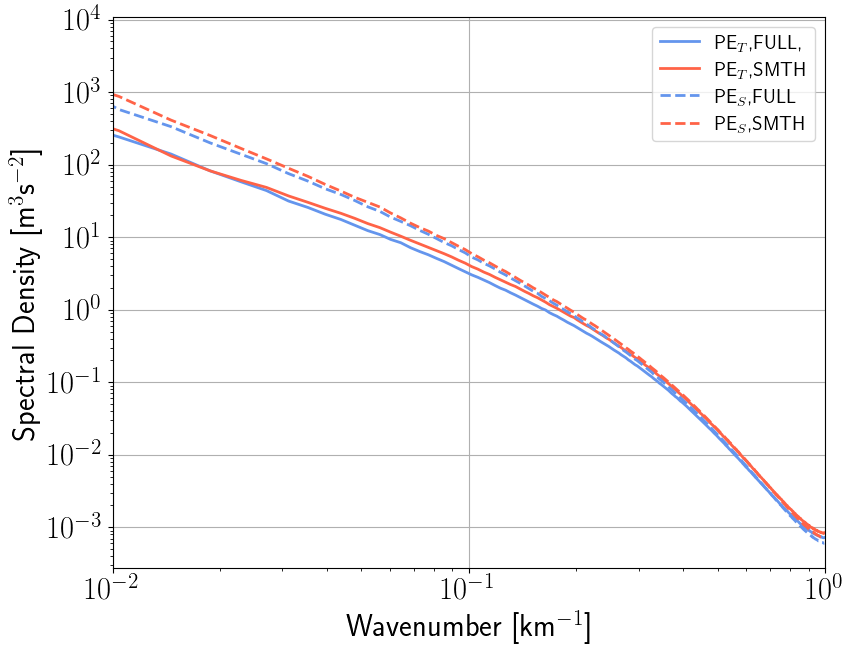

In [161]:
plt.figure(figsize=(9,7))


plt.plot((Epef.freq_r/dxx),Epe_alpha_f.mean(axis=0)/dxx*1e3,label=r'PE$_T$,FULL,',linewidth=2,color='cornflowerblue')
plt.plot((Epet.freq_r/dxx),Epe_alpha_t.mean(axis=0)/dxx*1e3,label=r'PE$_T$,SMTH',linewidth=2,color='tomato')

plt.plot((Epef.freq_r/dxx),Epe_beta_f.mean(axis=0)/dxx*1e3,label=r'PE$_S$,FULL',linewidth=2,linestyle='--',color='cornflowerblue')
plt.plot((Epet.freq_r/dxx),Epe_beta_t.mean(axis=0)/dxx*1e3,label=r'PE$_S$,SMTH',linewidth=2,linestyle='--',color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(fontsize=14)

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
plt.ylabel(r'Spectral Density [m$^{3}$s$^{-2}$]',fontweight='bold')


# plt.title(r'Surface PE',fontsize=25,fontweight='bold')
# plt.yscale('symlog', linthresh=1e-4)
plt.xscale('log')
plt.yscale('log')



# plt.ylim(0.001,.5)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/PEt,PEs.png')



## Plotting Ratio

In [72]:
R_f=(Ekef.data/Epef.data).mean(axis=0)
R_t=(Eket.data/Epet.data).mean(axis=0)

In [163]:
Rt_f=(Ekef.data/Epe_alpha_f.data).mean(axis=0)
Rt_t=(Eket.data/Epe_alpha_t.data).mean(axis=0)

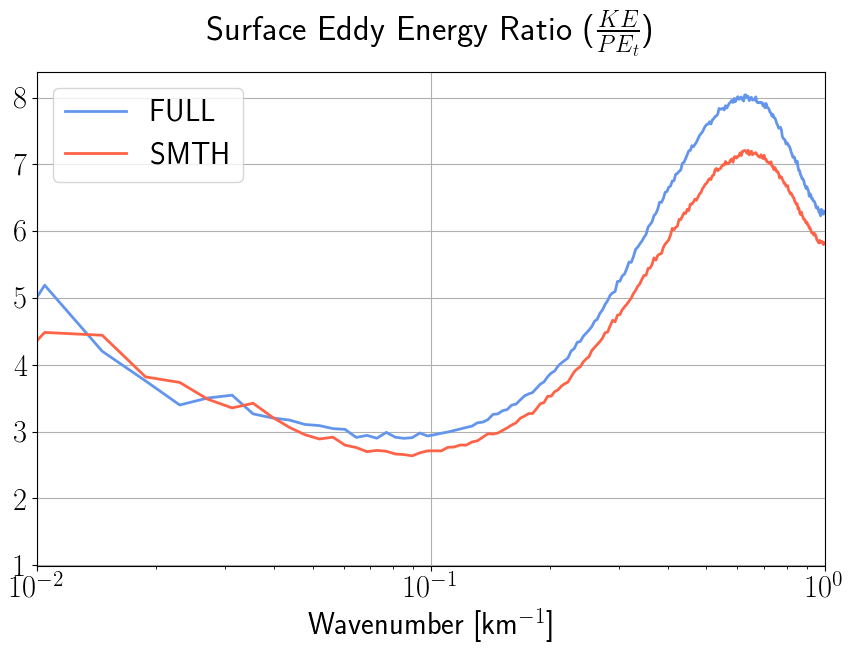

In [164]:

plt.figure(figsize=(10,8))


plt.plot((Ekef.freq_r/dxx),Rt_f,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((Eket.freq_r/dxx),Rt_t,label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
# plt.ylabel(r'Spectral Density',fontweight='bold')

plt.title(r'Surface Eddy Energy Ratio ($\frac{KE}{PE_t}$)',fontsize=25,fontweight='bold',y=1.05)
# plt.yscale('symlog', linthresh=1e-4)
plt.xscale('log')

# plt.ylim(0.001,2)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Ratio_KE-PEt.png')



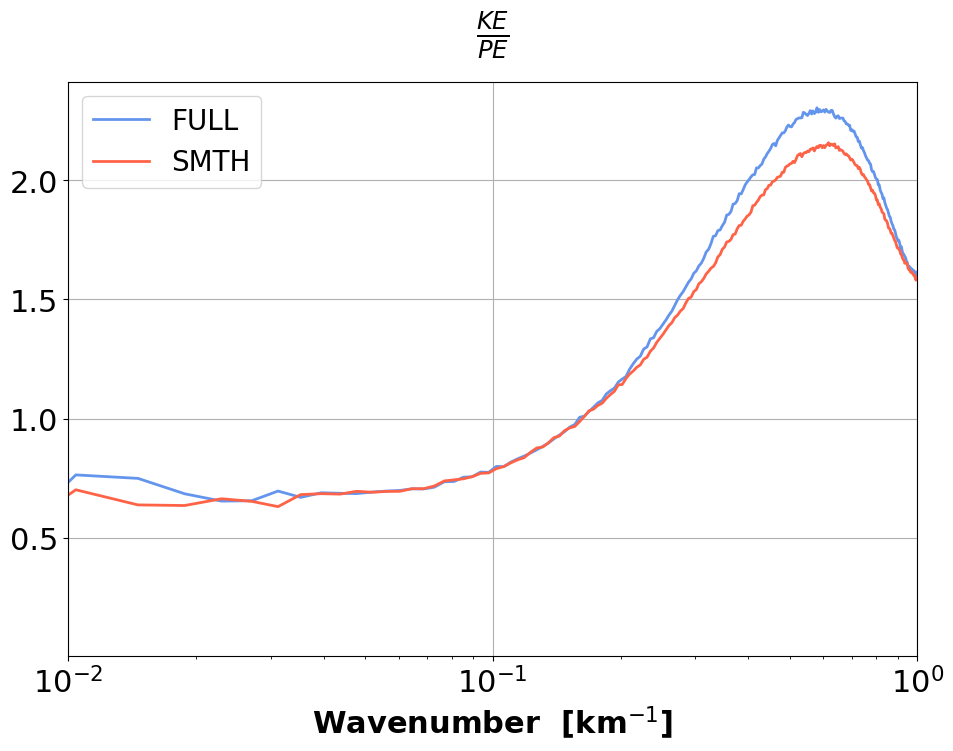

In [76]:

plt.figure(figsize=(10,8))


plt.plot((Ekef.freq_r/dxx),R_f,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((Eket.freq_r/dxx),R_t,label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(fontsize=20)

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
# plt.ylabel(r'Spectral Density',fontweight='bold')

plt.title(r'$\frac{KE}{PE}$',fontsize=25,fontweight='bold',y=1.05)
# plt.yscale('symlog', linthresh=1e-4)
plt.xscale('log')

# plt.ylim(0.001,2)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Ratio_PE-KE.png')


